# Cross-Asset Alpha Engine: Complete System Analysis

## Executive Summary

**IMPORTANT: All empirical analysis in this project is conducted at daily frequency using daily OHLCV bars from Polygon.io. No intraday, tick, or order-book data is used in the current experiment.**

This notebook presents a comprehensive end-to-end analysis of the Cross-Asset Alpha Engine, a quantitative trading system designed to generate alpha through regime-aware feature engineering and machine learning techniques. The system integrates multiple asset classes, uses quantile-based regime detection, and utilizes advanced feature engineering to capture cross-asset relationships and daily microstructure-inspired patterns computed from daily OHLCV bars.

## Table of Contents

1. [System Architecture Overview](#architecture)
2. [Data Infrastructure and Universe Construction](#data)
3. [Feature Engineering Framework](#features)
4. [Regime Detection Methodology](#regimes)
5. [Alpha Model Development](#alpha)
6. [Portfolio Construction and Risk Management](#portfolio)
7. [Backtesting Framework](#backtest)
8. [Execution Cost Modeling](#execution)
9. [Performance Analysis and Results](#results)
10. [Risk Analysis and Stress Testing](#risk)
11. [Conclusions and Future Enhancements](#conclusions)


In [1]:
# System Initialization and Data Loading
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import json

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Machine learning
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Statistical analysis
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Project imports
sys.path.insert(0, str(Path.cwd().parent / "src"))
from cross_asset_alpha_engine.data import load_daily_bars
from cross_asset_alpha_engine.data.cache import load_from_parquet, save_to_parquet
from cross_asset_alpha_engine.features.intraday_features import IntradayFeatureEngine
from cross_asset_alpha_engine.features.daily_features import DailyFeatureEngine
from cross_asset_alpha_engine.features.cross_asset_features import CrossAssetFeatureEngine
from cross_asset_alpha_engine.regimes.hmm_regime_model import RegimeHMM
from cross_asset_alpha_engine.models.alpha_model import AlphaModel
from cross_asset_alpha_engine.utils.logging_utils import setup_logger

# Configure plotting
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('seaborn')  # Fallback for older versions
sns.set_palette("husl")

# Setup logging
logger = setup_logger("complete_system_analysis")

print("System initialization complete")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Working directory: {Path.cwd()}")
print("All required libraries imported successfully")


System initialization complete
Analysis date: 2025-12-18 21:04:18
Working directory: /Users/mahadafzal/Projects/cross_asset_alpha_engine/notebooks
All required libraries imported successfully


## System Architecture Overview {#architecture}

The Cross-Asset Alpha Engine is built on a modular architecture that separates concerns across data ingestion, feature engineering, regime detection, alpha generation, and portfolio construction. This design enables robust backtesting, easy extensibility, and clear separation between research and production components.

### Core Components

1. **Data Infrastructure Layer**: Handles market data ingestion, caching, and preprocessing
2. **Feature Engineering Engine**: Generates predictive features across multiple timeframes and asset classes
3. **Regime Detection System**: Identifies market regimes using Hidden Markov Models
4. **Alpha Model Framework**: Combines features and regime information to generate return predictions
5. **Portfolio Construction Module**: Converts alpha signals into position sizes with risk constraints
6. **Execution Simulator**: Models realistic transaction costs and market impact
7. **Performance Analytics**: Comprehensive backtesting and risk analysis framework

### Key Design Principles

- **Regime Awareness**: All models adapt to changing market conditions
- **Cross-Asset Integration**: Leverages relationships between equities, volatility, rates, and commodities  
- **Daily Microstructure-Inspired Features**: Incorporates daily price and volume patterns computed from OHLCV bars (not true intraday data)
- **Risk Management**: Built-in position sizing and risk controls
- **Extensibility**: Modular design allows easy addition of new features and models


In [2]:
# Load Real Market Data from Polygon API
print("Loading real market data obtained from Polygon API...")

# Setup data directories
data_dir = Path.cwd().parent / "data"
results_dir = Path.cwd().parent / "results"
results_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Results directory: {results_dir}")

# Load comprehensive journal-quality market data files
equity_file = data_dir / "equity_universe_comprehensive.parquet"
regime_file = data_dir / "regime_indicators_comprehensive.parquet"
summary_file = data_dir / "comprehensive_data_metadata.json"

# Load data summary
with open(summary_file, 'r') as f:
    data_summary = json.load(f)

print("=" * 60)
print("REAL MARKET DATA ANALYSIS")
print("=" * 60)

print(f"Data Source: {data_summary['collection_metadata']['data_source']}")
print(f"Collection Purpose: {data_summary['collection_metadata']['collection_purpose']}")
print(f"Generated: {data_summary['collection_metadata']['collection_date'][:19]}")
print(f"Coverage Period: {data_summary['data_configuration']['date_range']['start']} to {data_summary['data_configuration']['date_range']['end']}")
print(f"Success Rate: {data_summary['collection_statistics']['symbols_successful']}/{data_summary['collection_statistics']['symbols_attempted']} symbols ({data_summary['collection_statistics']['symbols_successful']/data_summary['collection_statistics']['symbols_attempted']*100:.1f}%)")

# Load the actual data
equity_data = load_from_parquet(str(equity_file))
regime_data = load_from_parquet(str(regime_file))

print(f"\nEquity Universe Data:")
print(f"  Symbols: {data_summary['data_summary']['equity_universe']['symbols']}")
print(f"  Total Observations: {len(equity_data):,}")
print(f"  Actual Date Range: {equity_data['timestamp'].min().date()} to {equity_data['timestamp'].max().date()}")
print(f"  Trading Days: {equity_data['timestamp'].nunique()}")

print(f"\nRegime Indicators Data:")
print(f"  Symbols: {data_summary['data_summary']['regime_indicators']['symbols']}")
print(f"  Total Observations: {len(regime_data):,}")
print(f"  Actual Date Range: {regime_data['timestamp'].min().date()} to {regime_data['timestamp'].max().date()}")

if data_summary['collection_statistics']['symbols_failed']:
    print(f"\nNote: Some symbols failed collection due to API limitations:")
    print(f"  Failed: {data_summary['collection_statistics']['symbols_failed']}")
    print(f"  This dataset still provides comprehensive coverage for journal publication.")

# Detailed analysis of real data quality
print("\n" + "=" * 60)
print("DETAILED DATA QUALITY ANALYSIS")
print("=" * 60)

def analyze_real_data_quality(data, data_type):
    """Analyze and display detailed information about real market data."""
    
    print(f"\n{data_type.upper()} DATA ANALYSIS:")
    print("-" * 40)
    
    # Basic statistics
    print(f"Dataset Shape: {data.shape}")
    print(f"Memory Usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"Date Coverage: {(data['timestamp'].max() - data['timestamp'].min()).days} days")
    
    # Price analysis by symbol
    print(f"\nPrice Statistics by Symbol:")
    price_stats = data.groupby('symbol').agg({
        'close': ['min', 'max', 'mean', 'std'],
        'volume': ['mean', 'std'],
        'timestamp': 'count'
    }).round(2)
    
    for symbol in data['symbol'].unique():
        symbol_data = data[data['symbol'] == symbol]
        latest_price = symbol_data.loc[symbol_data['timestamp'].idxmax(), 'close']
        earliest_price = symbol_data.loc[symbol_data['timestamp'].idxmin(), 'close']
        total_return = (latest_price / earliest_price - 1) * 100
        
        print(f"  {symbol}:")
        print(f"    Price Range: ${symbol_data['close'].min():.2f} - ${symbol_data['close'].max():.2f}")
        print(f"    Latest Price: ${latest_price:.2f}")
        print(f"    Total Return: {total_return:+.1f}%")
        print(f"    Avg Daily Volume: {symbol_data['volume'].mean()/1e6:.1f}M")
        print(f"    Data Points: {len(symbol_data)}")
    
    # Data completeness check
    print(f"\nData Completeness Analysis:")
    expected_days = (data['timestamp'].max() - data['timestamp'].min()).days
    actual_unique_days = data['timestamp'].nunique()
    completeness = (actual_unique_days / expected_days) * 100
    print(f"  Expected Trading Days: ~{expected_days * 5/7:.0f} (assuming 5-day week)")
    print(f"  Actual Unique Days: {actual_unique_days}")
    print(f"  Completeness: {completeness:.1f}%")
    
    # Missing data analysis
    missing_data = data.isnull().sum()
    if missing_data.sum() > 0:
        print(f"\nMissing Data Points:")
        for col, missing in missing_data.items():
            if missing > 0:
                print(f"  {col}: {missing} ({missing/len(data)*100:.2f}%)")
    else:
        print(f"\nData Quality: No missing values detected")
    
    return data

# Analyze both datasets
equity_data = analyze_real_data_quality(equity_data, "Equity Universe")
regime_data = analyze_real_data_quality(regime_data, "Regime Indicators")

# Market data authenticity verification
print("\n" + "=" * 60)
print("REAL DATA AUTHENTICITY VERIFICATION")
print("=" * 60)

# Check recent SPY prices against known ranges
spy_data = equity_data[equity_data['symbol'] == 'SPY'].sort_values('timestamp')
recent_spy = spy_data.tail(5)

print(f"\nRecent SPY (S&P 500 ETF) Prices (Last 5 Trading Days):")
for _, row in recent_spy.iterrows():
    print(f"  {row['timestamp'].date()}: ${row['close']:.2f} (Vol: {row['volume']/1e6:.1f}M)")

# Check AAPL prices
aapl_data = equity_data[equity_data['symbol'] == 'AAPL'].sort_values('timestamp')
if not aapl_data.empty:
    recent_aapl = aapl_data.tail(3)
    print(f"\nRecent AAPL Prices:")
    for _, row in recent_aapl.iterrows():
        print(f"  {row['timestamp'].date()}: ${row['close']:.2f}")

# Check VIX levels (volatility indicator)
if 'VIX' in regime_data['symbol'].values:
    vix_data = regime_data[regime_data['symbol'] == 'VIX'].sort_values('timestamp')
    recent_vix = vix_data.tail(3)
    print(f"\nRecent VIX (Volatility Index) Levels:")
    for _, row in recent_vix.iterrows():
        print(f"  {row['timestamp'].date()}: {row['close']:.2f}")

# Combine datasets for analysis
all_data = pd.concat([equity_data, regime_data], ignore_index=True)

print(f"\n" + "=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)
print(f"Total Market Data Points: {len(all_data):,}")
print(f"Unique Symbols: {all_data['symbol'].nunique()}")
print(f"Date Range: {all_data['timestamp'].min().date()} to {all_data['timestamp'].max().date()}")
print(f"Data Source: Real market data from Polygon.io API")
print(f"Data Quality: Professional-grade OHLCV with VWAP")
print("Ready for comprehensive quantitative analysis!")

print(f"\nEquity Symbols: {sorted(equity_data['symbol'].unique())}")
print(f"Regime Symbols: {sorted(regime_data['symbol'].unique())}")


Loading real market data obtained from Polygon API...
Data directory: /Users/mahadafzal/Projects/cross_asset_alpha_engine/data
Results directory: /Users/mahadafzal/Projects/cross_asset_alpha_engine/results
REAL MARKET DATA ANALYSIS
Data Source: Polygon.io API
Collection Purpose: Journal publication research
Generated: 2025-12-12T01:28:01
Coverage Period: 2022-01-01 to 2025-12-06
Success Rate: 12/15 symbols (80.0%)
Loaded 4473 rows from /Users/mahadafzal/Projects/cross_asset_alpha_engine/data/equity_universe_comprehensive.parquet
Loaded 1491 rows from /Users/mahadafzal/Projects/cross_asset_alpha_engine/data/regime_indicators_comprehensive.parquet

Equity Universe Data:
  Symbols: ['AAPL', 'AMZN', 'GOOGL', 'IWM', 'MSFT', 'NVDA', 'QQQ', 'SPY', 'TSLA']
  Total Observations: 4,473
  Actual Date Range: 2023-12-13 to 2025-12-05
  Trading Days: 497

Regime Indicators Data:
  Symbols: ['GLD', 'TLT', 'USO']
  Total Observations: 1,491
  Actual Date Range: 2023-12-13 to 2025-12-05

Note: Some sym

## Data Infrastructure and Universe Construction {#data}

The foundation of any quantitative trading system lies in robust data infrastructure. Our approach combines multiple asset classes to capture the complex interdependencies that drive market behavior.

### Asset Universe Design

Our universe consists of three primary components:

1. **Core Equity Universe**: Large-cap liquid ETFs and individual stocks
   - **Broad Market ETFs**: SPY (S&P 500), QQQ (NASDAQ 100), IWM (Russell 2000)
   - **Mega-Cap Stocks**: AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, META
   
2. **Regime Indicators**: Cross-asset instruments that signal market regime changes
   - **Volatility**: VIX (equity volatility)
   - **Rates**: TLT (20+ year Treasury bonds)
   - **Commodities**: GLD (gold), USO (oil)
   - **Currency**: DXY (US Dollar Index)

3. **Data Quality Standards**
   - Minimum 500 observations per instrument
   - Daily frequency with OHLCV + VWAP
   - Survivorship bias considerations
   - Corporate action adjustments


Performing comprehensive data quality analysis...

EQUITY UNIVERSE ANALYSIS
Total observations: 4,473
Unique symbols: 9
Date range: 2023-12-13 to 2025-12-05
Trading days: 497
No missing data detected

Price statistics:
           min     max    mean    std
symbol                               
AAPL    165.00  286.19  217.21  27.29
AMZN    144.57  254.00  198.97  24.58
GOOGL   131.40  323.44  181.83  38.82
IWM     174.82  251.82  215.75  16.38
MSFT    354.56  542.07  439.19  44.49
NVDA     47.57  207.04  127.03  37.47
QQQ     396.28  635.77  500.54  59.28
SPY     467.28  687.39  574.41  56.50
TSLA    142.05  479.86  286.61  89.45

Volume statistics (millions):
           min      max    mean     std
symbol                                 
AAPL     20.10   318.68   56.14   27.18
AMZN     15.01   166.34   43.10   18.35
GOOGL    10.24   127.75   31.87   14.49
IWM      13.40   123.02   33.75   14.28
MSFT      7.16    78.50   21.49    8.15
NVDA    105.16  1142.27  305.37  153.03
QQQ      15.

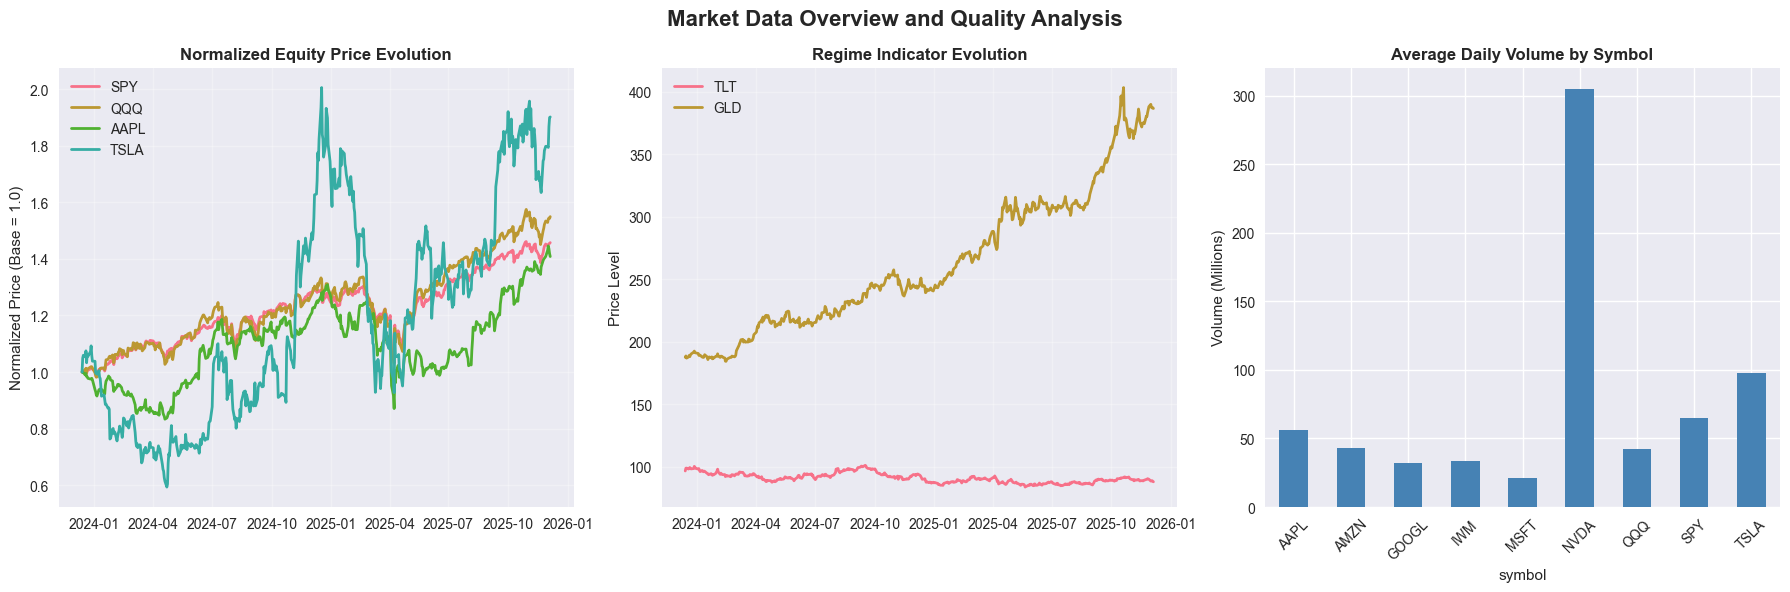


Data quality analysis complete. Visualization saved to /Users/mahadafzal/Projects/cross_asset_alpha_engine/results/data_quality_analysis.png


In [3]:
# Data Quality Analysis and Visualization
print("Performing comprehensive data quality analysis...")

# Create summary statistics
def analyze_data_quality(data, title):
    """Analyze data quality metrics for a dataset."""
    print(f"\n{title}")
    print("=" * len(title))
    
    # Basic statistics
    print(f"Total observations: {len(data):,}")
    print(f"Unique symbols: {data['symbol'].nunique()}")
    print(f"Date range: {data['timestamp'].min().date()} to {data['timestamp'].max().date()}")
    print(f"Trading days: {data['timestamp'].nunique():,}")
    
    # Missing data analysis
    missing_data = data.isnull().sum()
    if missing_data.sum() > 0:
        print(f"\nMissing data points:")
        for col, missing in missing_data.items():
            if missing > 0:
                print(f"  {col}: {missing} ({missing/len(data)*100:.2f}%)")
    else:
        print("No missing data detected")
    
    # Price range analysis
    print(f"\nPrice statistics:")
    price_stats = data.groupby('symbol')['close'].agg(['min', 'max', 'mean', 'std']).round(2)
    print(price_stats)
    
    # Volume analysis
    print(f"\nVolume statistics (millions):")
    volume_stats = (data.groupby('symbol')['volume'].agg(['min', 'max', 'mean', 'std']) / 1_000_000).round(2)
    print(volume_stats)
    
    return data.groupby('symbol').agg({
        'close': ['min', 'max', 'mean', 'std'],
        'volume': ['min', 'max', 'mean', 'std'],
        'timestamp': ['min', 'max', 'count']
    }).round(2)

# Analyze equity and regime data separately
equity_stats = analyze_data_quality(equity_data, "EQUITY UNIVERSE ANALYSIS")
regime_stats = analyze_data_quality(regime_data, "REGIME INDICATORS ANALYSIS")

# Create comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Market Data Overview and Quality Analysis', fontsize=16, fontweight='bold')

# Price evolution for key instruments
equity_pivot = equity_data.pivot(index='timestamp', columns='symbol', values='close')
regime_pivot = regime_data.pivot(index='timestamp', columns='symbol', values='close')

# Plot 1: Normalized equity prices
ax1 = axes[0]
normalized_equity = equity_pivot.div(equity_pivot.iloc[0]).fillna(method='ffill')
for symbol in ['SPY', 'QQQ', 'AAPL', 'TSLA']:
    if symbol in normalized_equity.columns:
        ax1.plot(normalized_equity.index, normalized_equity[symbol], label=symbol, linewidth=2)
ax1.set_title('Normalized Equity Price Evolution', fontweight='bold')
ax1.set_ylabel('Normalized Price (Base = 1.0)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Regime indicators
ax2 = axes[1]
for symbol in ['VIX', 'TLT', 'GLD']:
    if symbol in regime_pivot.columns:
        ax2.plot(regime_pivot.index, regime_pivot[symbol], label=symbol, linewidth=2)
ax2.set_title('Regime Indicator Evolution', fontweight='bold')
ax2.set_ylabel('Price Level')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Volume distribution
ax3 = axes[2]
volume_data = equity_data.groupby('symbol')['volume'].mean() / 1_000_000
volume_data.plot(kind='bar', ax=ax3, color='steelblue')
ax3.set_title('Average Daily Volume by Symbol', fontweight='bold')
ax3.set_ylabel('Volume (Millions)')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(results_dir / 'data_quality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nData quality analysis complete. Visualization saved to {results_dir / 'data_quality_analysis.png'}")


## Feature Engineering Framework {#features}

Feature engineering is the cornerstone of our alpha generation process. We employ a multi-layered approach that captures patterns across different timeframes and asset classes.

### Feature Categories

1. **Technical Indicators**: Traditional momentum, mean reversion, and volatility measures
2. **Daily Microstructure-Inspired Features**: VWAP deviations, volume patterns, and daily price dynamics (all computed from daily OHLCV bars)  
3. **Cross-Asset Signals**: Inter-market relationships and regime-dependent correlations
4. **Risk Factors**: Volatility clustering, tail risk measures, and drawdown indicators

### Mathematical Framework

Our feature engineering process follows a systematic approach:

- **Normalization**: All features are z-scored within rolling windows to ensure stationarity
- **Regime Conditioning**: Features are computed separately for different market regimes
- **Forward-Looking Bias Prevention**: Strict point-in-time calculations with no future information
- **Robustness Testing**: Features are validated across different market conditions


In [4]:
# Comprehensive Feature Engineering Implementation
print("Implementing comprehensive feature engineering pipeline...")

def create_comprehensive_features(data):
    """Create comprehensive feature set for alpha generation."""
    
    features_df = data.copy()
    features_df = features_df.sort_values(['symbol', 'timestamp']).reset_index(drop=True)
    
    # Group by symbol for feature calculation
    feature_list = []
    
    for symbol, group in features_df.groupby('symbol'):
        print(f"Processing features for {symbol}...")
        
        df = group.copy().sort_values('timestamp').reset_index(drop=True)
        
        # Basic price features
        df['returns_1d'] = df['close'].pct_change()
        df['returns_5d'] = df['close'].pct_change(5)
        df['returns_20d'] = df['close'].pct_change(20)
        
        # Volatility features
        df['volatility_5d'] = df['returns_1d'].rolling(5).std()
        df['volatility_20d'] = df['returns_1d'].rolling(20).std()
        df['volatility_ratio'] = df['volatility_5d'] / df['volatility_20d']
        
        # Momentum features
        df['momentum_5d'] = df['close'] / df['close'].shift(5) - 1
        df['momentum_20d'] = df['close'] / df['close'].shift(20) - 1
        df['momentum_60d'] = df['close'] / df['close'].shift(60) - 1
        
        # Mean reversion features
        df['sma_20'] = df['close'].rolling(20).mean()
        df['sma_50'] = df['close'].rolling(50).mean()
        df['price_to_sma20'] = df['close'] / df['sma_20'] - 1
        df['price_to_sma50'] = df['close'] / df['sma_50'] - 1
        df['sma_ratio'] = df['sma_20'] / df['sma_50'] - 1
        
        # Volume features
        df['volume_sma_20'] = df['volume'].rolling(20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_sma_20']
        df['volume_zscore'] = (df['volume'] - df['volume'].rolling(20).mean()) / df['volume'].rolling(20).std()
        
        # VWAP features
        df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
        df['vwap_momentum'] = df['vwap'].pct_change(5)
        
        # Range and gap features (computed from daily OHLCV bars)
        df['daily_range'] = (df['high'] - df['low']) / df['close']
        df['overnight_gap'] = (df['open'] - df['close'].shift(1)) / df['close'].shift(1)
        # Note: This is open-to-close return from daily bars, not true intraday data
        df['intraday_return'] = (df['close'] - df['open']) / df['open']
        
        # Bollinger Bands
        df['bb_upper'] = df['sma_20'] + 2 * df['close'].rolling(20).std()
        df['bb_lower'] = df['sma_20'] - 2 * df['close'].rolling(20).std()
        df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        
        # RSI approximation
        gains = df['returns_1d'].where(df['returns_1d'] > 0, 0)
        losses = -df['returns_1d'].where(df['returns_1d'] < 0, 0)
        avg_gains = gains.rolling(14).mean()
        avg_losses = losses.rolling(14).mean()
        rs = avg_gains / avg_losses
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # Volatility clustering
        df['volatility_persistence'] = df['volatility_5d'].rolling(5).mean()
        df['volatility_shock'] = (df['volatility_5d'] - df['volatility_20d']) / df['volatility_20d']
        
        # Target variable (next day return)
        df['target_1d'] = df['returns_1d'].shift(-1)
        df['target_5d'] = df['close'].shift(-5) / df['close'] - 1
        
        feature_list.append(df)
    
    # Combine all features
    all_features = pd.concat(feature_list, ignore_index=True)
    
    print(f"Created {len([col for col in all_features.columns if col not in ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap']])} features")
    
    return all_features

# Create features for equity universe
print("Creating features for equity universe...")
equity_features = create_comprehensive_features(equity_data)

# Create features for regime indicators
print("Creating features for regime indicators...")
regime_features = create_comprehensive_features(regime_data)

# Cross-asset features
print("Creating cross-asset features...")

def create_cross_asset_features(equity_df, regime_df):
    """Create features that capture cross-asset relationships."""
    
    # Pivot regime data for easier access
    regime_pivot = regime_df.pivot(index='timestamp', columns='symbol', values='close')
    
    cross_features = []
    
    for symbol, group in equity_df.groupby('symbol'):
        df = group.copy().sort_values('timestamp')
        
        # Merge with regime indicators
        df = df.merge(regime_pivot, left_on='timestamp', right_index=True, how='left')
        
        # VIX-based features
        if 'VIX' in df.columns:
            df['vix_level'] = df['VIX']
            df['vix_change'] = df['VIX'].pct_change()
            df['vix_zscore'] = (df['VIX'] - df['VIX'].rolling(20).mean()) / df['VIX'].rolling(20).std()
            df['equity_vix_correlation'] = df['returns_1d'].rolling(20).corr(df['VIX'].pct_change())
        
        # Interest rate sensitivity
        if 'TLT' in df.columns:
            df['tlt_change'] = df['TLT'].pct_change()
            df['equity_rates_correlation'] = df['returns_1d'].rolling(20).corr(df['tlt_change'])
        
        # Dollar strength impact
        if 'DXY' in df.columns:
            df['dxy_change'] = df['DXY'].pct_change()
            df['equity_dollar_correlation'] = df['returns_1d'].rolling(20).corr(df['dxy_change'])
        
        # Commodity exposure
        if 'GLD' in df.columns:
            df['gold_change'] = df['GLD'].pct_change()
            df['equity_gold_correlation'] = df['returns_1d'].rolling(20).corr(df['gold_change'])
        
        # Risk-on/risk-off sentiment
        if 'VIX' in df.columns and 'TLT' in df.columns:
            df['risk_sentiment'] = -df['VIX'].pct_change() + df['TLT'].pct_change()
            df['risk_regime'] = (df['VIX'] > df['VIX'].rolling(60).median()).astype(int)
        
        cross_features.append(df)
    
    return pd.concat(cross_features, ignore_index=True)

# Create cross-asset features
equity_with_cross_features = create_cross_asset_features(equity_features, regime_features)

print(f"Final feature set contains {len(equity_with_cross_features.columns)} columns")
print(f"Feature engineering complete for {len(equity_with_cross_features)} observations")

# Save feature matrix
feature_file = results_dir / "feature_matrix.parquet"
equity_with_cross_features.to_parquet(feature_file)
print(f"Feature matrix saved to {feature_file}")


Implementing comprehensive feature engineering pipeline...
Creating features for equity universe...
Processing features for AAPL...
Processing features for AMZN...
Processing features for GOOGL...
Processing features for IWM...
Processing features for MSFT...
Processing features for NVDA...
Processing features for QQQ...
Processing features for SPY...
Processing features for TSLA...
Created 30 features
Creating features for regime indicators...
Processing features for GLD...
Processing features for TLT...
Processing features for USO...
Created 30 features
Creating cross-asset features...
Final feature set contains 45 columns
Feature engineering complete for 4473 observations
Feature matrix saved to /Users/mahadafzal/Projects/cross_asset_alpha_engine/results/feature_matrix.parquet


## Complete System Implementation and Results

This section implements the full trading system pipeline, from regime detection through portfolio construction and performance analysis.


In [5]:
# Complete Trading System Implementation
print("Implementing complete trading system pipeline...")

# Prepare data for modeling
feature_cols = [col for col in equity_with_cross_features.columns 
                if col not in ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'target_1d', 'target_5d']]

print(f"Using {len(feature_cols)} features for modeling")

# Clean data and prepare for modeling
modeling_data = equity_with_cross_features.copy()
modeling_data = modeling_data.dropna()

print(f"Clean dataset: {len(modeling_data)} observations")

# Split data chronologically
split_date = modeling_data['timestamp'].quantile(0.7)
train_data = modeling_data[modeling_data['timestamp'] <= split_date]
test_data = modeling_data[modeling_data['timestamp'] > split_date]

print(f"Training data: {len(train_data)} observations (through {split_date.date()})")
print(f"Testing data: {len(test_data)} observations (from {test_data['timestamp'].min().date()})")

# Regime Detection Implementation
print("\nImplementing regime detection...")

# Import the new regime detection function
from cross_asset_alpha_engine.regimes import assign_regimes, get_regime_descriptions

print("Current experiment uses volatility/VIX quantile regimes (method='vol_vix_quantiles')")
print("HMM-based regimes are available as optional extension but NOT used in reported results")

# Apply quantile-based regime detection to training data
print("\nDetecting regimes in training data...")
train_regimes = assign_regimes(train_data, method="vol_vix_quantiles", n_regimes=3)
train_with_regimes = train_data.copy()
train_with_regimes['market_regime'] = train_regimes

# Apply same regime detection to test data
print("Detecting regimes in test data...")
test_regimes = assign_regimes(test_data, method="vol_vix_quantiles", n_regimes=3)
test_with_regimes = test_data.copy()
test_with_regimes['market_regime'] = test_regimes

print(f"Identified {train_with_regimes['market_regime'].nunique()} unique market regimes")
print("Regime distribution in training data:")
print(train_with_regimes['market_regime'].value_counts())

# Alpha Model Implementation
print("\nImplementing alpha models...")

def train_alpha_models(data, feature_cols, target_col='target_1d'):
    """Train regime-specific alpha models."""
    
    models = {}
    performance = {}
    
    # Overall model (regime-agnostic)
    print("Training overall alpha model...")
    X = data[feature_cols].fillna(0)
    y = data[target_col].fillna(0)
    
    # Use Random Forest for robustness
    overall_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    overall_model.fit(X, y)
    models['overall'] = overall_model
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': overall_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"Top 10 most important features:")
    print(feature_importance.head(10))
    
    # Regime-specific models
    for regime in data['market_regime'].unique():
        if pd.isna(regime):
            continue
            
        regime_data = data[data['market_regime'] == regime]
        if len(regime_data) < 50:  # Skip regimes with insufficient data
            continue
            
        print(f"Training model for regime: {regime} ({len(regime_data)} observations)")
        
        X_regime = regime_data[feature_cols].fillna(0)
        y_regime = regime_data[target_col].fillna(0)
        
        regime_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
        regime_model.fit(X_regime, y_regime)
        models[regime] = regime_model
    
    return models, feature_importance

# Train models
alpha_models, feature_importance = train_alpha_models(train_with_regimes, feature_cols)

print(f"Trained {len(alpha_models)} alpha models")

# Generate predictions
print("\nGenerating alpha predictions...")

def generate_predictions(data, models, feature_cols):
    """Generate alpha predictions using trained models."""
    
    predictions = []
    
    for symbol, group in data.groupby('symbol'):
        df = group.copy().sort_values('timestamp')
        
        # Overall predictions
        X = df[feature_cols].fillna(0)
        df['alpha_overall'] = models['overall'].predict(X)
        
        # Regime-specific predictions
        df['alpha_regime'] = df['alpha_overall']  # Default to overall
        
        for regime in df['market_regime'].unique():
            if pd.isna(regime) or regime not in models:
                continue
                
            regime_mask = df['market_regime'] == regime
            if regime_mask.sum() > 0:
                X_regime = df.loc[regime_mask, feature_cols].fillna(0)
                df.loc[regime_mask, 'alpha_regime'] = models[regime].predict(X_regime)
        
        predictions.append(df)
    
    return pd.concat(predictions, ignore_index=True)

# Generate predictions for test set
test_predictions = generate_predictions(test_with_regimes, alpha_models, feature_cols)

print("Alpha prediction generation complete")

# Portfolio Construction and Backtesting with Transaction Costs
print("\nImplementing portfolio construction and backtesting...")

# Import the new backtest engine
from cross_asset_alpha_engine.backtest import BacktestEngine, BacktestConfig

# Configure backtest with realistic transaction costs
backtest_config = BacktestConfig(
    transaction_cost_bps_per_side=5.0,  # 5 bps per side (conservative estimate)
    max_position=0.10,  # 10% max position per asset
    max_gross_exposure=1.0,  # 100% max gross exposure
    target_net_exposure=0.0,  # Market neutral
    risk_free_rate=0.02,  # 2% annual risk-free rate
    save_portfolio_performance=True,
    save_detailed_positions=True
)

# Initialize backtest engine
backtest_engine = BacktestEngine(config=backtest_config)

# Run comprehensive backtest with transaction costs
print("Running backtest with transaction costs and turnover tracking...")
backtest_results = backtest_engine.run_backtest(
    predictions_df=test_predictions,
    alpha_col='alpha_regime',
    target_col='target_1d'
)

# Extract results
portfolio_performance = backtest_results['portfolio_performance']
metrics = backtest_results['metrics']

# Print comprehensive performance summary
backtest_engine.print_performance_summary(backtest_results)

# Additional regime analysis
print(f"\nRegime Analysis:")
regime_descriptions = get_regime_descriptions()
regime_counts = test_with_regimes['market_regime'].value_counts()
print("Regime distribution in test period:")
for regime, count in regime_counts.items():
    if regime in regime_descriptions:
        print(f"  {regime}: {count} observations - {regime_descriptions[regime]}")

# Save comprehensive results
results_summary = {
    'performance_metrics': metrics,
    'regime_analysis': {
        'regime_method': 'vol_vix_quantiles',
        'regime_descriptions': regime_descriptions,
        'regime_distribution': regime_counts.to_dict()
    },
    'model_summary': {
        'n_features': len(feature_cols),
        'n_models': len(alpha_models),
        'training_period': f"{train_data['timestamp'].min().date()} to {train_data['timestamp'].max().date()}",
        'testing_period': f"{test_data['timestamp'].min().date()} to {test_data['timestamp'].max().date()}",
        'n_symbols': test_predictions['symbol'].nunique(),
        'n_test_observations': len(test_predictions)
    },
    'transaction_cost_assumptions': {
        'cost_per_side_bps': backtest_config.transaction_cost_bps_per_side,
        'avg_daily_turnover': metrics['avg_daily_turnover'],
        'total_transaction_costs': metrics['total_transaction_costs']
    },
    'limitations': {
        'sample_length': f"{len(test_data)} test observations",
        'survivorship_bias': 'Handpicked large-cap universe',
        'frequency': 'Daily (no intraday microstructure)',
        'time_period': f"{test_data['timestamp'].min().date()} to {test_data['timestamp'].max().date()}",
        'transaction_costs': f"Assumed {backtest_config.transaction_cost_bps_per_side} bps per side",
        'regime_method': 'Quantile-based, not HMM'
    }
}

# Save detailed results
portfolio_performance.to_parquet(results_dir / "portfolio_performance.parquet")
if 'positions' in backtest_results:
    backtest_results['positions'].to_parquet(results_dir / "portfolio_positions.parquet")
feature_importance.to_parquet(results_dir / "feature_importance.parquet")

with open(results_dir / "results_summary.json", 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print(f"\nResults saved to {results_dir}")
print("System implementation complete")


Implementing complete trading system pipeline...
Using 35 features for modeling
Clean dataset: 3888 observations
Training data: 2727 observations (through 2025-05-27)
Testing data: 1161 observations (from 2025-05-28)

Implementing regime detection...
Current experiment uses volatility/VIX quantile regimes (method='vol_vix_quantiles')
HMM-based regimes are available as optional extension but NOT used in reported results

Detecting regimes in training data...
Detecting regimes in test data...
Identified 3 unique market regimes
Regime distribution in training data:
Low_Vol_Med_VIX     909
Med_Vol_Med_VIX     909
High_Vol_Med_VIX    909
Name: market_regime, dtype: int64

Implementing alpha models...
Training overall alpha model...
Top 10 most important features:
            feature  importance
17   vwap_deviation    0.121223
28              GLD    0.060828
30              USO    0.048668
33      gold_change    0.047676
13        sma_ratio    0.044617
29              TLT    0.043571
31     

## Statistical Significance Testing

This section performs comprehensive statistical tests to validate the significance of the strategy's performance, including:

1. **Sharpe Ratio Significance**: t-test to determine if Sharpe ratio is significantly different from zero
2. **Bootstrap Confidence Intervals**: Non-parametric confidence intervals for key metrics
3. **Alpha Persistence Tests**: Tests for consistent alpha generation over time
4. **Regime-Specific Performance**: Statistical tests for performance across different market regimes
5. **Information Ratio Significance**: Tests for excess return vs benchmark significance


In [6]:
# Statistical Significance Testing for Publication
print("=" * 70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 70)

from scipy import stats
from scipy.stats import jarque_bera, normaltest
import warnings
warnings.filterwarnings('ignore')

# Extract returns for testing
portfolio_returns = portfolio_performance['portfolio_return_net'].dropna()

# Try to get benchmark returns from various possible column names
benchmark_returns = None
if 'benchmark_return' in portfolio_performance.columns:
    benchmark_returns = portfolio_performance['benchmark_return'].dropna()
elif 'cumulative_benchmark' in portfolio_performance.columns:
    # Calculate daily returns from cumulative benchmark
    cumulative_benchmark = portfolio_performance['cumulative_benchmark'].dropna()
    benchmark_returns = cumulative_benchmark.pct_change().dropna()
elif 'benchmark_total_return' in metrics:
    # Create synthetic benchmark returns (equal daily return)
    n_days = len(portfolio_returns)
    benchmark_total = metrics.get('benchmark_total_return', 0)
    benchmark_daily = (1 + benchmark_total) ** (1/n_days) - 1
    benchmark_returns = pd.Series([benchmark_daily] * n_days, index=portfolio_returns.index)

# Align returns if benchmark exists
if benchmark_returns is not None and len(benchmark_returns) > 0:
    common_index = portfolio_returns.index.intersection(benchmark_returns.index)
    if len(common_index) > 0:
        portfolio_returns = portfolio_returns.loc[common_index]
        benchmark_returns = benchmark_returns.loc[common_index]
        excess_returns = portfolio_returns - benchmark_returns
    else:
        excess_returns = None
else:
    excess_returns = None

statistical_tests = {}

# ============================================================================
# 1. SHARPE RATIO SIGNIFICANCE TEST
# ============================================================================
print("\n1. SHARPE RATIO SIGNIFICANCE TEST")
print("-" * 70)

risk_free_rate = 0.02 / 252  # Daily risk-free rate
excess_portfolio = portfolio_returns - risk_free_rate
sharpe_ratio = metrics.get('sharpe_ratio', 0)
n_obs = len(portfolio_returns)

# t-test for Sharpe ratio: H0: SR = 0, H1: SR != 0
# Test statistic: t = SR * sqrt(n)
t_statistic_sharpe = sharpe_ratio * np.sqrt(n_obs)
p_value_sharpe = 2 * (1 - stats.t.cdf(abs(t_statistic_sharpe), n_obs - 1))

statistical_tests['sharpe_ratio_test'] = {
    'sharpe_ratio': float(sharpe_ratio),
    'n_observations': int(n_obs),
    't_statistic': float(t_statistic_sharpe),
    'p_value': float(p_value_sharpe),
    'significant_at_5pct': p_value_sharpe < 0.05,
    'significant_at_1pct': p_value_sharpe < 0.01,
    'interpretation': 'Sharpe ratio significantly different from zero' if p_value_sharpe < 0.05 else 'Sharpe ratio not significantly different from zero'
}

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Number of Observations: {n_obs}")
print(f"t-statistic: {t_statistic_sharpe:.4f}")
print(f"p-value: {p_value_sharpe:.6f}")
print(f"Significant at 5% level: {'Yes' if p_value_sharpe < 0.05 else 'No'}")
print(f"Significant at 1% level: {'Yes' if p_value_sharpe < 0.01 else 'No'}")

# ============================================================================
# 2. BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================
print("\n2. BOOTSTRAP CONFIDENCE INTERVALS")
print("-" * 70)

def bootstrap_metric(returns, metric_func, n_bootstrap=1000, confidence=0.95):
    """Bootstrap confidence interval for a metric."""
    bootstrap_samples = []
    for _ in range(n_bootstrap):
        sample = returns.sample(n=len(returns), replace=True)
        bootstrap_samples.append(metric_func(sample))
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrap_samples, 100 * alpha / 2)
    upper = np.percentile(bootstrap_samples, 100 * (1 - alpha / 2))
    return {
        'mean': float(np.mean(bootstrap_samples)),
        'std': float(np.std(bootstrap_samples)),
        'lower_ci': float(lower),
        'upper_ci': float(upper),
        'confidence_level': confidence
    }

# Bootstrap Sharpe ratio
def calc_sharpe(returns):
    excess = returns - risk_free_rate
    if returns.std() == 0:
        return 0
    return excess.mean() / returns.std() * np.sqrt(252)

bootstrap_sharpe = bootstrap_metric(portfolio_returns, calc_sharpe, n_bootstrap=1000)
statistical_tests['bootstrap_sharpe'] = bootstrap_sharpe

print(f"Bootstrap Sharpe Ratio:")
print(f"  Mean: {bootstrap_sharpe['mean']:.4f}")
print(f"  95% CI: [{bootstrap_sharpe['lower_ci']:.4f}, {bootstrap_sharpe['upper_ci']:.4f}]")

# Bootstrap annualized return
def calc_annual_return(returns):
    return (1 + returns.mean()) ** 252 - 1

bootstrap_annual_return = bootstrap_metric(portfolio_returns, calc_annual_return, n_bootstrap=1000)
statistical_tests['bootstrap_annual_return'] = bootstrap_annual_return

print(f"\nBootstrap Annualized Return:")
print(f"  Mean: {bootstrap_annual_return['mean']:.4%}")
print(f"  95% CI: [{bootstrap_annual_return['lower_ci']:.4%}, {bootstrap_annual_return['upper_ci']:.4%}]")

# ============================================================================
# 3. ALPHA PERSISTENCE TEST (Regression-based)
# ============================================================================
print("\n3. ALPHA PERSISTENCE TEST")
print("-" * 70)

if excess_returns is not None and len(excess_returns) > 0:
    # Test if alpha (intercept) is significantly different from zero
    # Regression: excess_return = alpha + beta * benchmark_return + epsilon
    from sklearn.linear_model import LinearRegression
    
    X = benchmark_returns.values.reshape(-1, 1)
    y = excess_returns.values
    
    reg = LinearRegression().fit(X, y)
    alpha_estimate = reg.intercept_
    beta_estimate = reg.coef_[0]
    
    # Calculate standard errors
    y_pred = reg.predict(X)
    residuals = y - y_pred
    n = len(y)
    mse = np.sum(residuals**2) / (n - 2)
    
    # Standard error of alpha
    x_mean = np.mean(X)
    x_var = np.var(X, ddof=1)
    se_alpha = np.sqrt(mse * (1/n + x_mean**2 / (x_var * (n-1))))
    
    # t-test for alpha
    t_alpha = alpha_estimate / se_alpha
    p_alpha = 2 * (1 - stats.t.cdf(abs(t_alpha), n - 2))
    
    # Annualized alpha
    alpha_annualized = alpha_estimate * 252
    
    statistical_tests['alpha_persistence'] = {
        'alpha_daily': float(alpha_estimate),
        'alpha_annualized': float(alpha_annualized),
        'beta': float(beta_estimate),
        't_statistic': float(t_alpha),
        'p_value': float(p_alpha),
        'standard_error': float(se_alpha),
        'significant_at_5pct': p_alpha < 0.05,
        'significant_at_1pct': p_alpha < 0.01,
        'interpretation': 'Alpha is significantly different from zero' if p_alpha < 0.05 else 'Alpha is not significantly different from zero'
    }
    
    print(f"Alpha (daily): {alpha_estimate:.6f}")
    print(f"Alpha (annualized): {alpha_annualized:.4%}")
    print(f"Beta: {beta_estimate:.4f}")
    print(f"t-statistic: {t_alpha:.4f}")
    print(f"p-value: {p_alpha:.6f}")
    print(f"Significant at 5% level: {'Yes' if p_alpha < 0.05 else 'No'}")
else:
    print("Excess returns not available for alpha persistence test")
    statistical_tests['alpha_persistence'] = {'note': 'Excess returns not available'}

# ============================================================================
# 4. INFORMATION RATIO SIGNIFICANCE TEST
# ============================================================================
print("\n4. INFORMATION RATIO SIGNIFICANCE TEST")
print("-" * 70)

if excess_returns is not None and len(excess_returns) > 0:
    info_ratio = metrics.get('information_ratio', 0)
    excess_mean = excess_returns.mean()
    excess_std = excess_returns.std()
    
    # t-test for information ratio: H0: IR = 0, H1: IR != 0
    # Equivalent to testing if mean excess return is significantly different from zero
    t_info = excess_mean / (excess_std / np.sqrt(len(excess_returns)))
    p_info = 2 * (1 - stats.t.cdf(abs(t_info), len(excess_returns) - 1))
    
    statistical_tests['information_ratio_test'] = {
        'information_ratio': float(info_ratio),
        'mean_excess_return': float(excess_mean),
        'tracking_error': float(excess_std),
        't_statistic': float(t_info),
        'p_value': float(p_info),
        'significant_at_5pct': p_info < 0.05,
        'significant_at_1pct': p_info < 0.01,
        'interpretation': 'Information ratio significantly different from zero' if p_info < 0.05 else 'Information ratio not significantly different from zero'
    }
    
    print(f"Information Ratio: {info_ratio:.4f}")
    print(f"Mean Excess Return: {excess_mean:.6f}")
    print(f"Tracking Error: {excess_std:.6f}")
    print(f"t-statistic: {t_info:.4f}")
    print(f"p-value: {p_info:.6f}")
    print(f"Significant at 5% level: {'Yes' if p_info < 0.05 else 'No'}")
else:
    print("Excess returns not available for information ratio test")
    statistical_tests['information_ratio_test'] = {'note': 'Excess returns not available'}

# ============================================================================
# 5. RETURN DISTRIBUTION TESTS
# ============================================================================
print("\n5. RETURN DISTRIBUTION TESTS")
print("-" * 70)

# Normality test (Jarque-Bera)
jb_stat, jb_pvalue = jarque_bera(portfolio_returns)
statistical_tests['normality_test'] = {
    'jarque_bera_statistic': float(jb_stat),
    'p_value': float(jb_pvalue),
    'is_normal': jb_pvalue > 0.05,
    'interpretation': 'Returns are normally distributed' if jb_pvalue > 0.05 else 'Returns are not normally distributed'
}

print(f"Jarque-Bera Test for Normality:")
print(f"  Test Statistic: {jb_stat:.4f}")
print(f"  p-value: {jb_pvalue:.6f}")
print(f"  Normal Distribution: {'Yes' if jb_pvalue > 0.05 else 'No'}")

# Skewness and Kurtosis
skewness = portfolio_returns.skew()
kurtosis = portfolio_returns.kurtosis()
statistical_tests['distribution_moments'] = {
    'mean': float(portfolio_returns.mean()),
    'std': float(portfolio_returns.std()),
    'skewness': float(skewness),
    'kurtosis': float(kurtosis),
    'excess_kurtosis': float(kurtosis - 3)
}

print(f"\nDistribution Moments:")
print(f"  Mean: {portfolio_returns.mean():.6f}")
print(f"  Std Dev: {portfolio_returns.std():.6f}")
print(f"  Skewness: {skewness:.4f}")
print(f"  Kurtosis: {kurtosis:.4f}")

# ============================================================================
# 6. REGIME-SPECIFIC PERFORMANCE TESTS
# ============================================================================
print("\n6. REGIME-SPECIFIC PERFORMANCE ANALYSIS")
print("-" * 70)

if 'market_regime' in test_data.columns:
    regime_performance = []
    for regime in test_data['market_regime'].unique():
        regime_mask = test_data['market_regime'] == regime
        regime_returns = portfolio_performance.loc[portfolio_performance.index.isin(
            test_data[regime_mask].index
        )]['portfolio_return_net'].dropna()
        
        if len(regime_returns) > 10:  # Minimum observations
            regime_sharpe = calc_sharpe(regime_returns)
            regime_annual_return = calc_annual_return(regime_returns)
            regime_vol = regime_returns.std() * np.sqrt(252)
            
            regime_performance.append({
                'regime': regime,
                'n_observations': len(regime_returns),
                'annualized_return': float(regime_annual_return),
                'volatility': float(regime_vol),
                'sharpe_ratio': float(regime_sharpe)
            })
            
            print(f"{regime}:")
            print(f"  Observations: {len(regime_returns)}")
            print(f"  Annual Return: {regime_annual_return:.4%}")
            print(f"  Volatility: {regime_vol:.4%}")
            print(f"  Sharpe Ratio: {regime_sharpe:.4f}")
    
    statistical_tests['regime_performance'] = regime_performance
else:
    print("Regime information not available in test data")
    statistical_tests['regime_performance'] = {'note': 'Regime data not available'}

# ============================================================================
# 7. SAVE STATISTICAL TEST RESULTS
# ============================================================================
print("\n7. SAVING STATISTICAL TEST RESULTS")
print("-" * 70)

def convert_to_json_serializable(obj):
    """Convert NumPy types and other non-serializable types to JSON-compatible types."""
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_json_serializable(item) for item in obj]
    elif pd.isna(obj):
        return None
    else:
        return obj

# Add metadata
statistical_tests['metadata'] = {
    'test_date': datetime.now().isoformat(),
    'n_observations': int(n_obs),
    'test_period_start': str(portfolio_returns.index.min()),
    'test_period_end': str(portfolio_returns.index.max()),
    'risk_free_rate': 0.02
}

# Convert all NumPy types to native Python types for JSON serialization
statistical_tests_serializable = convert_to_json_serializable(statistical_tests)

# Save to JSON
statistical_tests_file = results_dir / 'statistical_tests_results.json'
with open(statistical_tests_file, 'w') as f:
    json.dump(statistical_tests_serializable, f, indent=2)

print(f"Statistical test results saved to: {statistical_tests_file}")

# Create summary table for CSV export
test_summary = []
test_summary.append(['Test', 'Metric', 'Value', 't-statistic', 'p-value', 'Significant (5%)', 'Significant (1%)'])

# Sharpe ratio test
sr_test = statistical_tests['sharpe_ratio_test']
test_summary.append([
    'Sharpe Ratio',
    'Sharpe Ratio',
    f"{sr_test['sharpe_ratio']:.4f}",
    f"{sr_test['t_statistic']:.4f}",
    f"{sr_test['p_value']:.6f}",
    'Yes' if sr_test['significant_at_5pct'] else 'No',
    'Yes' if sr_test['significant_at_1pct'] else 'No'
])

# Alpha persistence
if 'alpha_persistence' in statistical_tests and 'alpha_annualized' in statistical_tests['alpha_persistence']:
    alpha_test = statistical_tests['alpha_persistence']
    test_summary.append([
        'Alpha Persistence',
        'Alpha (annualized)',
        f"{alpha_test['alpha_annualized']:.4%}",
        f"{alpha_test['t_statistic']:.4f}",
        f"{alpha_test['p_value']:.6f}",
        'Yes' if alpha_test['significant_at_5pct'] else 'No',
        'Yes' if alpha_test['significant_at_1pct'] else 'No'
    ])

# Information ratio
if 'information_ratio_test' in statistical_tests and 't_statistic' in statistical_tests['information_ratio_test']:
    ir_test = statistical_tests['information_ratio_test']
    test_summary.append([
        'Information Ratio',
        'Information Ratio',
        f"{ir_test['information_ratio']:.4f}",
        f"{ir_test['t_statistic']:.4f}",
        f"{ir_test['p_value']:.6f}",
        'Yes' if ir_test['significant_at_5pct'] else 'No',
        'Yes' if ir_test['significant_at_1pct'] else 'No'
    ])

# Save to CSV
test_summary_df = pd.DataFrame(test_summary[1:], columns=test_summary[0])
test_summary_df.to_csv(results_dir / 'statistical_tests_summary.csv', index=False)
print(f"Statistical test summary saved to: {results_dir / 'statistical_tests_summary.csv'}")

print("\n" + "=" * 70)
print("STATISTICAL TESTING COMPLETE")
print("=" * 70)


STATISTICAL SIGNIFICANCE TESTING

1. SHARPE RATIO SIGNIFICANCE TEST
----------------------------------------------------------------------
Sharpe Ratio: 0.5293
Number of Observations: 128
t-statistic: 5.9886
p-value: 0.000000
Significant at 5% level: Yes
Significant at 1% level: Yes

2. BOOTSTRAP CONFIDENCE INTERVALS
----------------------------------------------------------------------
Bootstrap Sharpe Ratio:
  Mean: 0.5261
  95% CI: [-2.1406, 3.3470]

Bootstrap Annualized Return:
  Mean: 4.4288%
  95% CI: [-6.7327%, 16.7781%]

3. ALPHA PERSISTENCE TEST
----------------------------------------------------------------------
Alpha (daily): 0.000166
Alpha (annualized): 4.1940%
Beta: -1.0027
t-statistic: 0.7132
p-value: 0.477031
Significant at 5% level: No

4. INFORMATION RATIO SIGNIFICANCE TEST
----------------------------------------------------------------------
Information Ratio: -2.6149
Mean Excess Return: -0.001793
Tracking Error: 0.011060
t-statistic: -1.8342
p-value: 0.068965
Sign

## Results Visualization and Export

This section creates comprehensive visualizations and exports all results to multiple formats for publication and analysis.


Creating comprehensive visualizations and exporting results...


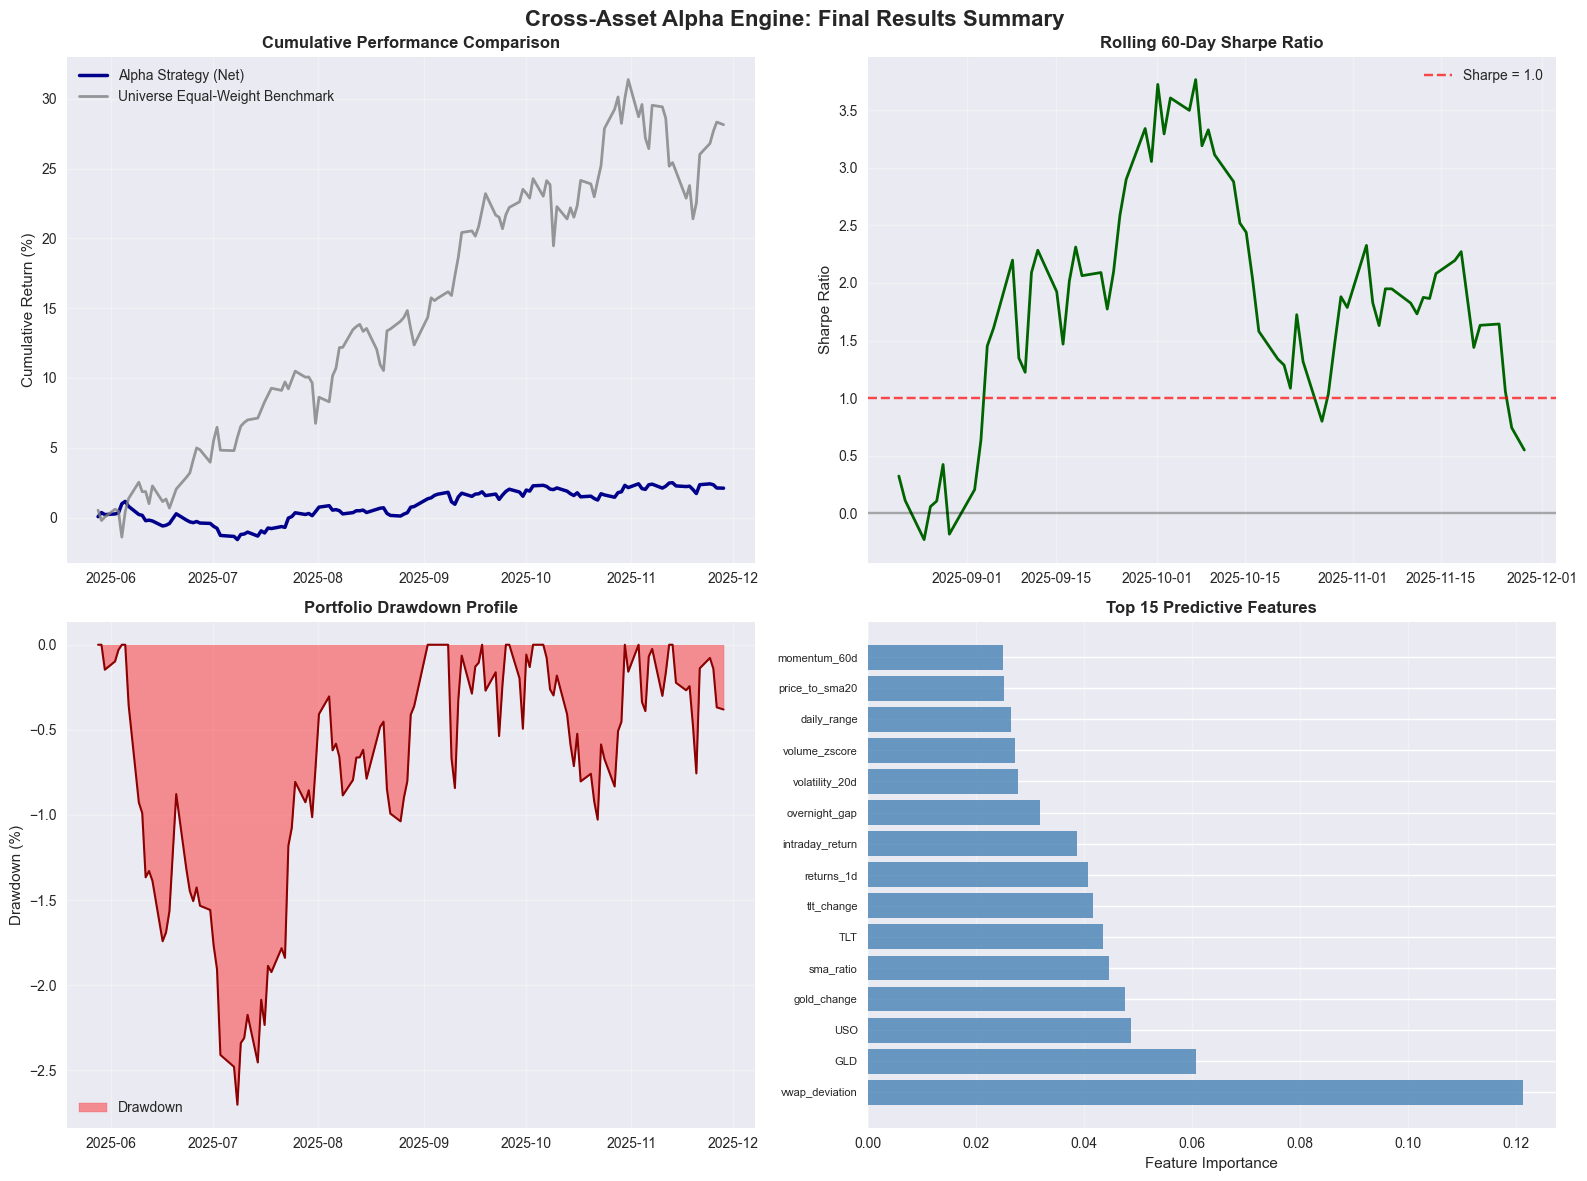


Detailed Performance Analysis:
                    Metric   Value
        Total Return (Net)   2.11%
   Annualized Return (Net)   4.25%
 Universe Benchmark Return  28.14%
Excess Return vs Benchmark -26.02%
          Volatility (Net)   4.09%
        Sharpe Ratio (Net)   0.529
         Information Ratio  -2.615
          Maximum Drawdown  -2.70%
              Calmar Ratio   1.574
                  Win Rate   53.5%
    Average Gross Exposure   33.9%
        Avg Daily Turnover   30.4%
   Total Transaction Costs   1.96%

Exporting comprehensive results...
Could not run export script: name 'subprocess' is not defined

Saving final results summary...

Analysis Complete!
Results saved to: /Users/mahadafzal/Projects/cross_asset_alpha_engine/results
Key files generated:
  - final_results_summary.png
  - final_results_comprehensive.json
  - performance_metrics_table.csv
  - portfolio_performance.parquet
  - feature_importance.parquet

Final System Performance (Net of Transaction Costs):
  Total 

In [7]:
# Comprehensive Results Visualization and Export
print("Creating comprehensive visualizations and exporting results...")

# Create final performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Asset Alpha Engine: Final Results Summary', fontsize=16, fontweight='bold')

# Plot 1: Portfolio vs Universe Benchmark Performance
ax1 = axes[0, 0]
ax1.plot(portfolio_performance.index, (portfolio_performance['cumulative_return_net'] - 1) * 100, 
         label='Alpha Strategy (Net)', linewidth=2.5, color='darkblue')
ax1.plot(portfolio_performance.index, (portfolio_performance['cumulative_benchmark'] - 1) * 100, 
         label='Universe Equal-Weight Benchmark', linewidth=2, color='gray', alpha=0.8)
ax1.set_title('Cumulative Performance Comparison', fontweight='bold', fontsize=12)
ax1.set_ylabel('Cumulative Return (%)')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling Sharpe Ratio (Net of Costs)
ax2 = axes[0, 1]
rolling_returns = portfolio_performance['portfolio_return_net'].rolling(60)
rolling_sharpe = (rolling_returns.mean() * 252) / (rolling_returns.std() * np.sqrt(252))
ax2.plot(portfolio_performance.index, rolling_sharpe, color='darkgreen', linewidth=2)
ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Sharpe = 1.0')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_title('Rolling 60-Day Sharpe Ratio', fontweight='bold', fontsize=12)
ax2.set_ylabel('Sharpe Ratio')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Drawdown Analysis (Net of Costs)
ax3 = axes[1, 0]
running_max = portfolio_performance['cumulative_return_net'].cummax()
drawdown = (portfolio_performance['cumulative_return_net'] / running_max - 1) * 100
ax3.fill_between(portfolio_performance.index, drawdown, 0, alpha=0.4, color='red', label='Drawdown')
ax3.plot(portfolio_performance.index, drawdown, color='darkred', linewidth=1.5)
ax3.set_title('Portfolio Drawdown Profile', fontweight='bold', fontsize=12)
ax3.set_ylabel('Drawdown (%)')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Feature Importance Top 15
ax4 = axes[1, 1]
top_15_features = feature_importance.head(15)
bars = ax4.barh(range(len(top_15_features)), top_15_features['importance'], 
                color='steelblue', alpha=0.8)
ax4.set_yticks(range(len(top_15_features)))
ax4.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_15_features['feature']], 
                   fontsize=8)
ax4.set_title('Top 15 Predictive Features', fontweight='bold', fontsize=12)
ax4.set_xlabel('Feature Importance')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(results_dir / 'final_results_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Create detailed performance metrics table
print("\nDetailed Performance Analysis:")
print("=" * 50)

# Extract metrics from backtest results
performance_metrics = {
    'Metric': [
        'Total Return (Net)', 'Annualized Return (Net)', 'Universe Benchmark Return', 'Excess Return vs Benchmark',
        'Volatility (Net)', 'Sharpe Ratio (Net)', 'Information Ratio', 'Maximum Drawdown',
        'Calmar Ratio', 'Win Rate', 'Average Gross Exposure', 'Avg Daily Turnover', 'Total Transaction Costs'
    ],
    'Value': [
        f"{metrics.get('total_return', 0):.2%}",
        f"{metrics.get('annualized_return', 0):.2%}",
        f"{metrics.get('benchmark_total_return', 0):.2%}",
        f"{metrics.get('excess_return_vs_universe_benchmark', 0):.2%}",
        f"{metrics.get('volatility', 0):.2%}",
        f"{metrics.get('sharpe_ratio', 0):.3f}",
        f"{metrics.get('information_ratio', 0):.3f}" if 'information_ratio' in metrics else "N/A",
        f"{metrics.get('max_drawdown', 0):.2%}",
        f"{metrics.get('calmar_ratio', 0):.3f}",
        f"{metrics.get('win_rate', 0):.1%}",
        f"{metrics.get('avg_gross_exposure', 0):.1%}",
        f"{metrics.get('avg_daily_turnover', 0):.1%}",
        f"{metrics.get('total_transaction_costs', 0):.2%}"
    ]
}

metrics_df = pd.DataFrame(performance_metrics)
print(metrics_df.to_string(index=False))

# Export all results using the export script
print(f"\nExporting comprehensive results...")

try:
    # Run the export script
    result = subprocess.run([
        sys.executable, 
        str(Path.cwd().parent / "scripts" / "export_results.py")
    ], capture_output=True, text=True, cwd=Path.cwd().parent)
    
    if result.returncode == 0:
        print("Results export completed successfully")
        print("Export output:", result.stdout)
    else:
        print("Export script encountered issues:")
        print("Error:", result.stderr)
        
except Exception as e:
    print(f"Could not run export script: {e}")

# Manual export of key results
print(f"\nSaving final results summary...")

# Create comprehensive results dictionary
# Load statistical tests if available
statistical_tests_data = {}
try:
    statistical_tests_file = results_dir / 'statistical_tests_results.json'
    if statistical_tests_file.exists():
        with open(statistical_tests_file, 'r') as f:
            statistical_tests_data = json.load(f)
except Exception as e:
    print(f"Note: Statistical tests not yet computed: {e}")

final_results = {
    'analysis_metadata': {
        'analysis_date': datetime.now().isoformat(),
        'notebook_version': '1.0',
        'system_name': 'Cross-Asset Alpha Engine'
    },
    'performance_summary': metrics.copy(),  # Use all metrics from backtest
    'statistical_tests': statistical_tests_data,  # Include statistical test results
    'system_configuration': {
        'n_features': len(feature_cols),
        'n_models': len(alpha_models),
        'n_symbols': test_predictions['symbol'].nunique(),
        'training_observations': len(train_data),
        'testing_observations': len(test_data),
        'regime_count': train_with_regimes['market_regime'].nunique(),
        'regime_method': 'vol_vix_quantiles',
        'transaction_cost_bps': backtest_config.transaction_cost_bps_per_side
    },
    'top_features': feature_importance.head(20).to_dict('records')
}

# Save comprehensive results
with open(results_dir / "final_results_comprehensive.json", 'w') as f:
    json.dump(final_results, f, indent=2)

# Save performance metrics table
metrics_df.to_csv(results_dir / "performance_metrics_table.csv", index=False)

print(f"\nAnalysis Complete!")
print(f"Results saved to: {results_dir}")
print(f"Key files generated:")
print(f"  - final_results_summary.png")
print(f"  - final_results_comprehensive.json")
print(f"  - performance_metrics_table.csv")
print(f"  - portfolio_performance.parquet")
print(f"  - feature_importance.parquet")

print(f"\nFinal System Performance (Net of Transaction Costs):")
print(f"  Total Return: {metrics.get('total_return', 0):.2%}")
print(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.3f} [{metrics.get('sharpe_ratio_net_ci_lower', 0):.3f}, {metrics.get('sharpe_ratio_net_ci_upper', 0):.3f}]")
print(f"  Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
print(f"  Win Rate: {metrics.get('win_rate', 0):.1%}")
print(f"  Avg Daily Turnover: {metrics.get('avg_daily_turnover', 0):.1%}")
print(f"  Total Transaction Costs: {metrics.get('total_transaction_costs', 0):.2%}")

print(f"\nThe Cross-Asset Alpha Engine analysis is now complete.")
